In [1]:
import sys
sys.path.append("..")  # Go up one level, where dynamicnanobrain / is located

import networkx as nx
import matplotlib.pyplot as plt
import time

# modules specific to this project
import dynamicnanobrain.core.networker as nw
# from dynamicnanobrain.core import physics
import dynamicnanobrain.core.timemarching as tm
from dynamicnanobrain.core import plotter
from dynamicnanobrain.core import logger

### 1. Define the broadcasting channels of the network
This is done by creating a list of the channel names. The names are arbitrary and can be set by the user, such as 'postive', 'negative' or explicit wavelenghts like '870 nm', '700 nm'. Here I chose the colors 'red' and 'blue'.

In [2]:
channel_list = ['red', 'blue']
# Automatically generate the object that handles them
channels = {channel_list[v] : v for v in range(len(channel_list))}

### 2. Define the layers
Define the layers of nodes in terms of how they are connected to the channels. Layers and weights are organized in dictionaries. The input and output layers do not need to be changed, but for the hidden layer we need to specify the number of nodes N and assign the correct channels to the input/output of the node.

In [3]:
# Create layers ordered from 0 to P organized in a dictionary
layers = {} 
device_config = '../parameters/device_parameters.txt'
# An input layer 
layers[0] = nw.InputLayer(N=1, path_to_file=device_config)
# Forward signal layer
layers[1] = nw.HiddenLayer(N=1, output_channel='blue',excitation_channel='blue',inhibition_channel='red', device=device_config)
# Inhibiting memory layer
layers[2] = nw.HiddenLayer(N=1, output_channel='red' ,excitation_channel='blue',inhibition_channel='red', device=device_config)
layers[3] = nw.OutputLayer(N=1, path_to_file=device_config) 

### 3. Define existing connections between layers
The weights are set in two steps. 

First the connetions between layers are defined. This should be done using the keys defined for each layer above, i.e. 0, 1, 2 ... for input, hidden and output layers, respectively. The `connect_layers` function returns a weight matrix object that we store under a chosen key, for example `'inp->hid'`.

Second, the specific connections on the node-to-node level are specified using the node index in each layer

In [4]:
# Define the overall connectivity
weights = {}
# The syntax is connect_layers(from_layer, to_layer, layers, channels)
weights['inp->hd0'] = nw.connect_layers(0, 1, layers, channel='blue')
#weights['inp->hd1'] = nw.connect_layers(0, 2, layers, channels)
#weights['hd0->hd1'] = nw.connect_layers(1, 2, layers, channels)
weights['hd0->out'] = nw.connect_layers(1, 3, layers, channel='blue')
#weights['hd1->out'] = nw.connect_layers(2, 3, layers, channels)
# Backwards connection from the memory
#weights['hd1->hd0'] = nw.connect_layers(2, 1, layers, channels)
# Teacher forcing connection back into the network
weights['out->hd1'] = nw.connect_layers(3, 2, layers, channel='blue')
# Define the specific node-to-node connections in the weight matrices
low_weight =  1.0 # 0.02
# The syntax is connect_nodes(from_node, to_node, channel=label, weight=value in weight matrix)

# Draw a ring network with Nring nodes (Nring defined above)

# Input to first ring layer node
weights['inp->hd0'].connect_nodes(0, 0, weight=1.0) # channels['blue']=1
#weights['inp->hd0'].connect_nodes(0, 0, weight=1.0) # channels['blue']=1
# Connect second hidden layer
#weights['inp->hd1'].connect_nodes(channels['blue'] ,0, channel='blue', weight=1.0) # channels['blue']=1
# Output layer connections back to network
#weights['out->hd1'].connect_nodes(channels['blue'] ,0 , channel='blue', weight=low_weight) 
# Add damping connection
#weights['hd1->hd0'].connect_nodes(0 ,0 , channel='red', weight=low_weight)    
# Connect to output
weights['hd0->out'].connect_nodes(0, 0, weight=0.9) # 0.9 makes it easier to distinguish lines in plots
#weights['hd1->out'].connect_nodes(0, channels['red'], channel='red', weight=0.9)

### 4. Visualize the network 
The `plotter` module supplies functions to visualize the network structure. The nodes are named by the layer type (Input, Hidden or Output) and the index. To supress the printing of weight values on each connection, please supply `show_edge_labels=False`.

#### Available layouts:
**multipartite**: Standard neural network appearance. Hard to see recurrent couplings within layers.  
**circular**: Nodes drawn as a circle  
**shell**: Layers drawn as concetric circles  
**kamada_kawai**: Optimization to minimize weighted internode distance in graph  
**spring**: Spring layout which is standard in `networkx` 
#
#### Shell layout
This is my current favorite. It is configured to plot the input and output nodes on the outside of the hidden layer circle, in a combined outer concentric circle.

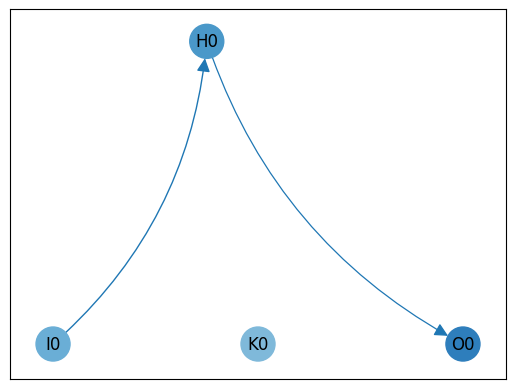

{'K0': array([0., 0.]),
 'H0': array([-0.16666669,  0.28867513]),
 'I0': array([-6.66666687e-01, -5.82818522e-08]),
 'O0': array([6.66666687e-01, 1.16563704e-07])}

In [5]:
plotter.visualize_network(layers, weights, layout='shell', show_edge_labels=False)

### 5. Specify the physics of the nodes
Before running any simulations, we need to specify the input currents and the physics of the hidden layer nodes. Parameters can either be specified directly or coupled from the `physics` module. 


In [6]:
# Specify two types of devices for the hidden layer
# 1. Propagator (standard parameters)
# UPDATE: All propagator parameters are inside the layers and automatically setup
# instead of using physics.Device() methods, directly use the Layer method
# propagator = physics.Device('../parameters/device_parameters.txt')
# propagator.print_parameter('Cstore')
print(f"Cstore: {layers[1].p_dict['Cstore']}")
#propagator.set_parameter('Rstore',1e6)
# 2. Memory (modify the parameters)
# memory = physics.Device('../parameters/device_parameters.txt')
#memory.set_parameter('Rstore',1e6)
#memory.set_parameter('Cstore',2e-15)
# a 3e-15 F capacitor can be build by 800x900 plates 20 nm apart
# memory.print_parameter('Cstore')
print(f"Cstore: {layers[2].p_dict['Cstore']}")

Cstore: 7e-17
Cstore: 7e-17


In [7]:
# Specify the internal dynamics by supplying the RC constants to the hidden layer (six parameters)
# layers[1].assign_device(propagator)
# layers[2].assign_device(memory)
# Tweak the threshold voltage
Vthres=0.5
layers[1].Vthres=Vthres
layers[2].Vthres=Vthres

# Calculate the unity_coeff to scale the weights accordingly
unity_coeff, Imax = layers[1].inverse_gain_coefficient()
print(f'Unity coupling coefficient calculated as unity_coeff={unity_coeff:.4f}')
print(f'Imax is found to be {Imax} nA')


Unity coupling coefficient calculated as unity_coeff=0.0236
Imax is found to be 187.4976562792965 nA


Produce Bode plots to determine what our frequency cutoff will be

In [8]:
# Setup the gain function
# eigvals = propagator.setup_gain(propagator.gammas)
eigvals = layers[1].setup_gain()

# The eigenvalues
print('System eigenvalues:')
k=0
for l in eigvals :
    print(f'eig[{k}]={l:.2f} ns^-1 ')
    k+=1
# Regarding the eigenvalues, eig[0]=-25.81 ns^-1, eig[1]=-5.00 ns^-1, eig[2]=-0.19 ns^-1
# eig[1] regards the charge collecting subsystem, this is their RC constant
# eig[0] regards the exchange between the collectors and the storage, I believe. For A33=20 it's zero
# eig[2] regards the time scale of the storage unit, the longest timescale in the system.
    
# PUT THIS IN THE PLOTTER MODULE
import numpy as np
# Visualize the response function 
Ns = 100
# Units are already in GHz so this creates a space from 1 MHz to 10 GHz
s_exp = np.linspace(-3,1,Ns)
s = 1j*10**s_exp

# Sample the gain function
# G11, _ = propagator.gain(s,eigvals,propagator.gammas)
G11, _ = layers[1].gain(s,eigvals)

mag_G11 = np.absolute(G11) / np.absolute(G11[0])
arg_G11 = np.angle(G11)

mag_G11_dB = 20*np.log10(mag_G11)

System eigenvalues:
eig[0]=-25.24 ns^-1 
eig[1]=-5.00 ns^-1 
eig[2]=-0.59 ns^-1 
eig[3]=-5.00 ns^-1 


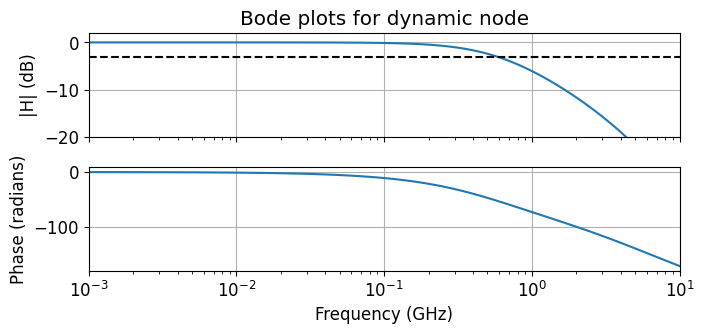

In [9]:
# Produce Bode plots of the results
# Define parameters
my_dpi = 300
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Figure sizes
inchmm = 25.4
nature_single = 89.0 / 25.4
nature_double = 183.0 / 25.4
nature_full = 247.0 / 25.4

# Plot options
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(nature_double,nature_single),sharex=True)

f_min = abs(s[0])
plot_f_max = 10 # GHz

ax1.plot(abs(s),mag_G11_dB)
ax1.plot([f_min,plot_f_max],[-3,-3],'k--')
ax1.grid('True')
ax1.set_xscale('log')
ax1.set_title('Bode plots for dynamic node')
#ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('|G11|/|G11[0]| (dB)')
ax1.set_ylabel('|H| (dB)')
ax1.set_xlim(f_min,plot_f_max)
ax1.set_ylim(-20,2)

ax2.plot(abs(s),arg_G11*180/np.pi)
ax2.grid('True')
#ax2.set_xscale('log')
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel('Phase (radians)')
ax2.set_ylim(-180,10)

figname = 'sine_test_bode'

plt.tight_layout()
#plt.legend()
plt.savefig(figname+'.eps',bbox_inches='tight')
plt.savefig(figname+'.png',dpi=my_dpi)
plt.savefig(figname+'.svg')
plt.show()


Use the physics of the device to configure a sine wave of changing frequency to use as an input signal


In [10]:
# Generate a time series using an increasing frequency series
def freqeuncy_step_generator(tend,fmin,fmax,factor=2,res=10) :
    # determine the size of the sequence
    dt = fmax**-1/res
    N = int(tend/dt)
    # chop it up into parts
    Nint = np.log(fmax/fmin)/np.log(factor)+1
    Nstep = int(N/Nint)
    changepoints = np.insert(np.arange(0,N,step=Nstep),int(Nint+1),N)
    # These are our frequencies
    freq = fmin*factor**np.arange(int(Nint)+1)
    # From here on we use the pyESN example code, with some modifications
    const_intervals = list(zip(changepoints,np.roll(changepoints,-1)))[:-1]
    frequency_control = np.zeros((N,1))
    for k, (t0,t1) in enumerate(const_intervals): # enumerate here
        frequency_control[t0:t1] = freq[k]
    
    # run time update through a sine, while changing the freqeuncy
    frequency_output = np.zeros((N,1))
    z = 0
    for i in range(N):
        z = z + frequency_control[i]*dt
        frequency_output[i] = (np.sin(z) + 1)/2
        
    tseries = np.arange(0,tend,step=dt)
    return np.hstack([np.ones((N,1)),frequency_control]),frequency_output,tseries
    
T = 1000 # ns
fmin = 0.05 # GHz
fmax = 1.6 # GHz

frequency_input, frequency_output, tseries = freqeuncy_step_generator(T,fmin,fmax) 

#print(f'Length of time: {len(time)}, Length of frequency output: {len(frequency_output)}')

# Now we use interpolation to get a function handle from these data
from scipy.interpolate import interp1d 
increase_freq = interp1d(tseries,frequency_output,axis=0)


In [11]:
# Specify an exciting current based on the frequency step function
def step_freq (t,I0) :
    return I0*increase_freq(t)

# Try to modulate the nodes with red input
t_red = [(8.0,9.0), (12.0,13.0)] # at 6 ns, 11 ns, and 16 ns
# Constant inhibition to stabilize circuit
I_red = 0.0 # nA

# Use the square pulse function and specify which node in the input layer gets which pulse
layers[0].set_input_func_per_node(0,func_handle=step_freq, func_args=(Imax,))
# Use the costant function to specify the inhibition from I0 to H0
#layers[0].set_input_func(channel='red', func_handle=physics.constant, func_args=I_red)
#layers[0].set_input_func(channel='red', func_handle=physics.square_pulse, func_args=(t_red, I_red))

### 6. Evolve in time

In [12]:
# Start time t, end time T
t = 0.0
T = 1000.0 # ns
# To sample result over a fixed time-step, use savetime
savestep = 1
savetime = savestep
# These parameters are used to determine an appropriate time step each update
dtmax = 0.1 # ns 
dVmax = 0.005 # V

nw.reset(layers)
# Create a log over the dynamic data
time_log = logger.Logger(layers,channels) # might need some flags

start = time.time()

while t < T:
    # evolve by calculating derivatives, provides dt
    dt = tm.evolve(t, layers, dVmax, dtmax )

    # update with explicit Euler using dt
    # supplying the unity_coeff here to scale the weights
    tm.update(dt, t, layers, weights, unity_coeff=unity_coeff)
    
    t += dt
    # Log the progress
    if t > savetime :
        # Put log update here to have (more or less) fixed sample rate
        time_log.add_tstep(t, layers, unity_coeff)
        # Now this is only to check progress
        print(f'Time at t={t} ns') 
        savetime += savestep

end = time.time()
print('Time used:',end-start)

# This is a large pandas data frame of all system variables
result = time_log.get_timelog()

Time at t=1.0413613166517246 ns
Time at t=2.056908174184939 ns
Time at t=3.0569081741849398 ns
Time at t=4.05690817418494 ns
Time at t=5.028544899899723 ns
Time at t=6.04429532948326 ns
Time at t=7.087892174807222 ns
Time at t=8.028254315971711 ns
Time at t=9.074119992037247 ns
Time at t=10.01139285745007 ns
Time at t=11.04090122179004 ns
Time at t=12.009616783554442 ns
Time at t=13.030417761228506 ns
Time at t=14.047044823081475 ns
Time at t=15.061347058475935 ns
Time at t=16.070645315404175 ns
Time at t=17.07770067823634 ns
Time at t=18.08425025110356 ns
Time at t=19.085323185714184 ns
Time at t=20.08592815266395 ns
Time at t=21.08277315905118 ns
Time at t=22.079554887547864 ns
Time at t=23.07632580816745 ns
Time at t=24.068297738949067 ns
Time at t=25.0616706263035 ns
Time at t=26.05136015841392 ns
Time at t=27.043270470790016 ns
Time at t=28.033264569009262 ns
Time at t=29.022830016205585 ns
Time at t=30.014068286883486 ns
Time at t=31.00534215514806 ns
Time at t=32.06228575771681 

### 7. Visualize results
Plot results specific to certain nodes

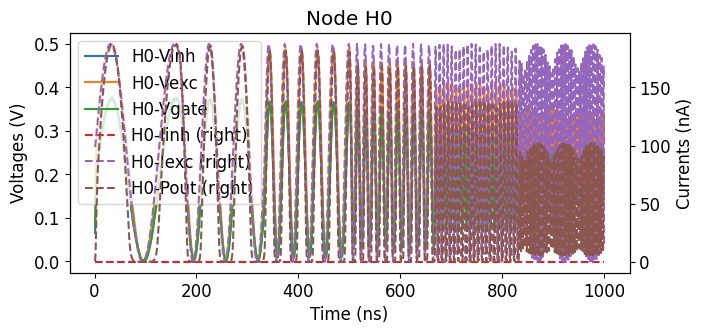

In [13]:
#nodes = ['H0','H1','H2','H3','H4']

nodes = ['H0']
plotter.plot_nodes(result, nodes)

For this system it's quite elegant to use the `plot_chainlist` function, taking as arguments a graph object, the source node (I1 for blue) and a target node (O1 for blue)

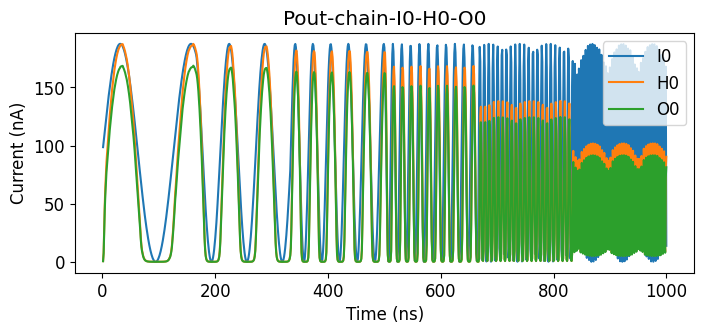

In [14]:
# Variable G contains a graph object descibing the network
G = plotter.retrieve_G(layers, weights)
plotter.plot_chainlist(result,G,'I0','O0')

Plot specific attributes

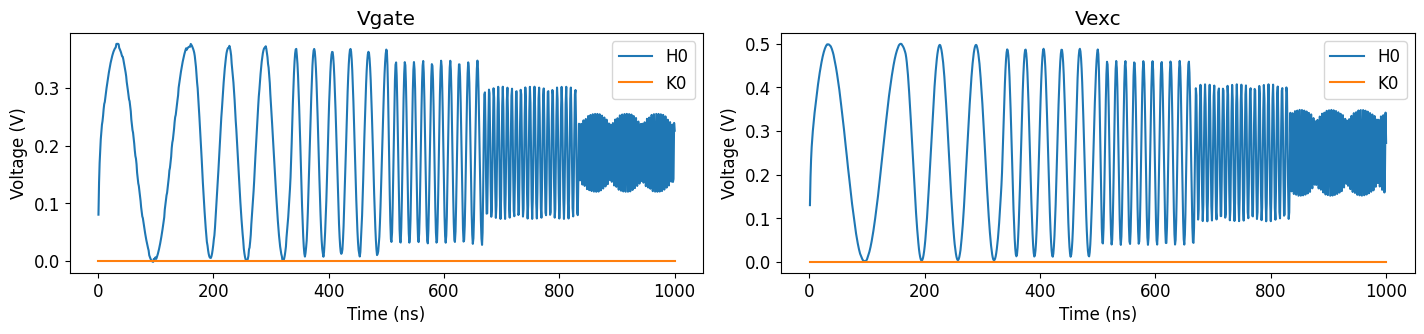

In [15]:
attr_list = ['Vgate','Vexc']
plotter.plot_attributes(result, attr_list)


We can be totally specific if we want. First we list the available columns to choose from

In [16]:
print(result.columns)

Index(['Time', 'I0-Pout', 'H0-Vinh', 'H0-Vexc', 'H0-Vgate', 'H0-Iinh',
       'H0-Iexc', 'H0-Iout', 'H0-ISD', 'H0-Pout', 'K0-Vinh', 'K0-Vexc',
       'K0-Vgate', 'K0-Iinh', 'K0-Iexc', 'K0-Iout', 'K0-ISD', 'K0-Pout',
       'O0-Pout', 'O0-Pinp'],
      dtype='object')


In [17]:
plotter.visualize_dynamic_result(result, ['I0-Iout-red','I1-Iout-blue'])

KeyError: "None of [Index(['I0-Iout-red', 'I1-Iout-blue'], dtype='object')] are in the [columns]"

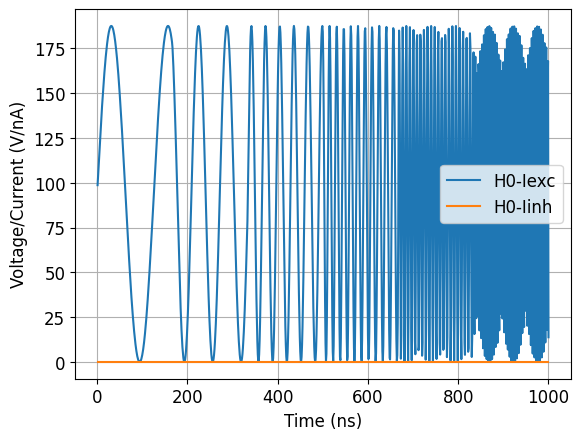

In [18]:
# The unit of H0-Iexc is V/ns, which is different compared to the other quantaties. 
# Consider removing or restructuring.
plotter.visualize_dynamic_result(result, ['H0-Iexc','H0-Iinh'])

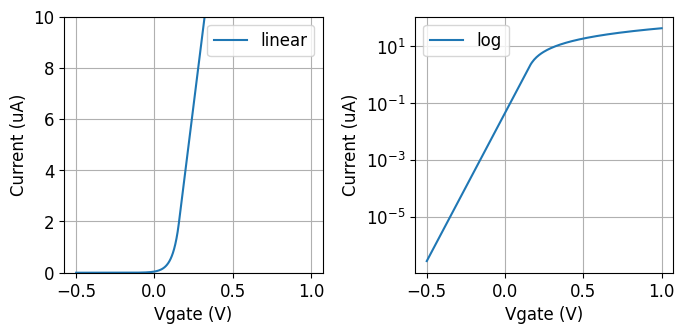

In [19]:
plotter.visualize_transistor(layers[1].transistorIV_example())

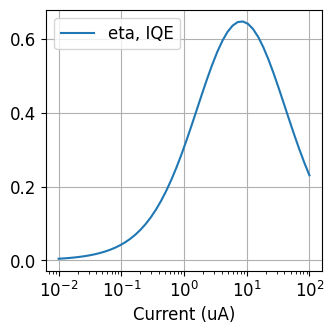

In [20]:
plotter.visualize_LED_efficiency(layers[1].eta_example(layers[1].eta_ABC))